## Code to perform binary classification of patients with pre-diabetes/lifestyle controlled diabetes and patients with diabetes needing medication.
### We first make sure that the dataframe for HbA1c contains only patients who also have CGM data so that the datasets are consistent across experiments


In [1]:
import pandas as pd

In [2]:
df_clinical = pd.read_csv(r"HbA1c_all_patients.csv")
df_clinical["HbA1c (%)"]

0       5.7
1       5.5
2       5.9
3       5.8
4       5.6
       ... 
1011    6.1
1012    6.9
1013    7.4
1014    5.5
1015    5.7
Name: HbA1c (%), Length: 1016, dtype: float64

In [3]:
# For consistency only pick patients who have CGM records
pkl_glucose_info = "dataframe_with_glucose_info.pkl"
dataframe_with_glucose_values_diabetes = pd.read_pickle(pkl_glucose_info)
df = dataframe_with_glucose_values_diabetes
print(df.shape)
print(df.columns)
# Pick only patients corresponding to prediabetes/life-style controlled diabetes and diabetes with medications.
df = df[df['study_group_id'].isin([1,2])]
df['study_group_id'] = df['study_group_id'] - 1
print(df.shape)
df_clinical = df_clinical[df_clinical['participant_id'].isin(df['patient_ids'])]
print(df_clinical.shape)

df_clinical.drop(columns=['Unnamed: 0'], inplace=True)
print(df_clinical.columns)

(1011, 10)
Index(['patient_ids', 'Glucose Lists', 'spike_resolutions',
       'expected_daily_spikes', 'mean_glucose', 'relative_spikes',
       'hyper_time_pcts', 'nocturnal_hypoglycemias', 'recommended_split',
       'study_group_id'],
      dtype='object')
(538, 10)
(511, 7)
Index(['participant_id', 'age', 'study_group', 'recommended_split',
       'clinical_site', 'HbA1c (%)'],
      dtype='object')


C:\Users\preet\AppData\Local\Temp\ipykernel_38324\1182915509.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['study_group_id'] = df['study_group_id'] - 1


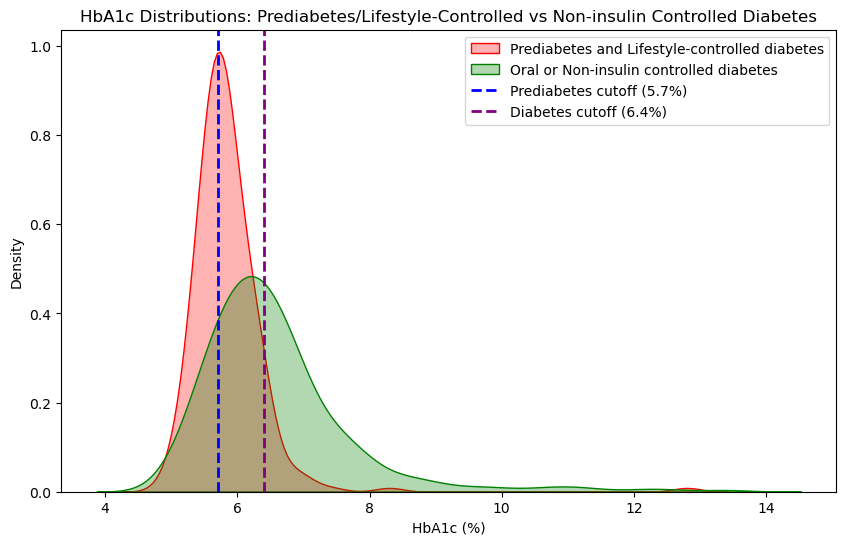

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop HbA1c values < 1
study1 = df_clinical.loc[
    (df_clinical["study_group"] == "pre_diabetes_lifestyle_controlled") &
    (df_clinical["HbA1c (%)"] >= 1),
    "HbA1c (%)"
]

study2 = df_clinical.loc[
    (df_clinical["study_group"] == "oral_medication_and_or_non_insulin_injectable_medication_controlled") &
    (df_clinical["HbA1c (%)"] >= 1),
    "HbA1c (%)"
]

# Plot overlapping filled distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(study1, color="red", label="Prediabetes and Lifestyle-controlled diabetes", fill=True, alpha=0.3)
sns.kdeplot(study2, color="green", label="Oral or Non-insulin controlled diabetes", fill=True, alpha=0.3)

# Add vertical lines at diagnostic cutoffs
plt.axvline(5.7, color="blue", linestyle="--", linewidth=2, label="Prediabetes cutoff (5.7%)")
plt.axvline(6.4, color="purple", linestyle="--", linewidth=2, label="Diabetes cutoff (6.4%)")

plt.xlabel("HbA1c (%)")
plt.ylabel("Density")
plt.title("HbA1c Distributions: Prediabetes/Lifestyle-Controlled vs Non-insulin Controlled Diabetes")
plt.legend()
plt.show()


In [9]:

df_all2 = df_clinical[['HbA1c (%)','recommended_split','study_group_id']]


In [10]:
# Try random forest classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score


df_train = df_all2[df_all2['recommended_split'] == 'train']
df_val   = df_all2[df_all2['recommended_split'] == 'val']
df_test  = df_all2[df_all2['recommended_split'] == 'test']
train_df = df_train.reset_index(drop=True)
val_df   = df_val.reset_index(drop=True)
test_df  = df_test.reset_index(drop=True)
col =  "study_group_id"
cols_to_drop = ['study_group_id','recommended_split']
X_train =  train_df.drop(columns=cols_to_drop)
y_train = train_df[col]
X_val =  val_df.drop(columns=cols_to_drop)
y_val = val_df[col]
X_test =  test_df.drop(columns=cols_to_drop)
y_test = test_df[col] 

print(X_train.columns)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=32, random_state=42, n_jobs=1)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# ROC AUC
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc:.4f}")


Index(['HbA1c (%)'], dtype='object')
Accuracy: 0.6621621621621622
Confusion Matrix:
 [[21 14]
 [11 28]]
Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.60      0.63        35
           2       0.67      0.72      0.69        39

    accuracy                           0.66        74
   macro avg       0.66      0.66      0.66        74
weighted avg       0.66      0.66      0.66        74

ROC AUC Score: 0.7278
